In [7]:
import pandas as pd
import os
import xarray as xr
xr.set_options(display_expand_attrs=True, display_width=1000, display_max_rows=1000)

import Model_Prediction
import importlib
importlib.reload(Model_Prediction)

<module 'Model_Prediction' from 'c:\\Users\\dias3\\Desktop\\FIRE-HACK\\Notebooks\\5Deployment\\backend\\utils\\Model_Prediction.py'>

In [8]:
# inputs da interface

duration = 5

mins_since_fire_start = 30

start_time = pd.to_datetime("2017-10-15 14:10:00")
start_time = start_time.round('30min')
print(start_time)

2017-10-15 14:00:00


In [9]:
master_file = "Data/Master_Table.nc"
ds_master = None

# ------------------- Checar se Master_Table existe -------------------
if os.path.exists(master_file):
    with xr.open_dataset(master_file) as ds:
        ds_master = ds.load()  # Carrega em memória e fecha o arquivo

# ------------------- Verificar se já existem dados válidos para todas as durations -------------------
data_exists = False
cols_to_check = ['fuel_load', 'pct_3_8', 'pct_8p', 'rh_2m', 
                 'wv100_kh', 'wdir_950', 'FWI_12h', 'predictions', 'linear_pred']

if ds_master is not None:
    valid = True
    for dur in range(1, duration + 1):
        try:
            df_slice = ds_master.sel(
                s_time=start_time,
                duration_hours=dur,
                fstart=mins_since_fire_start
            ).to_dataframe().reset_index()

            # Se nenhuma coluna de interesse tiver valor válido, a duração não está pronta
            if not df_slice[cols_to_check].notna().any().any():
                valid = False
                break  # não precisa checar as próximas durations

        except KeyError:
            valid = False
            break

    data_exists = valid

# ------------------- Extrair ou calcular -------------------
if data_exists:
    print("Dados já existentes no Master_Table. Extraindo...")
    # Extrair todas as durations de 1 até duration
    model_inputs = ds_master.sel(
        s_time=start_time,
        duration_hours=slice(1, duration),
        fstart=mins_since_fire_start
    ).to_dataframe().reset_index()
else:
    print("Calculando novos dados e atualizando Master_Table...")
    # Chama a função do Model_Prediction.py
    Model_Prediction.calculate_and_append_master(start_time, duration, mins_since_fire_start)

    # Depois de atualizar o NetCDF, abrir a fatia recém-calculada
    with xr.open_dataset(master_file) as ds:
        ds_master = ds.load()
        model_inputs = ds_master.sel(
            s_time=start_time,
            duration_hours=slice(1, duration),
            fstart=mins_since_fire_start
        ).to_dataframe().reset_index()

# ------------------- Limpar model_inputs -------------------
# Remover linhas onde **todas essas colunas** são NaN
model_inputs = model_inputs.dropna(subset=cols_to_check, how='all')

print(model_inputs.head())


Dados já existentes no Master_Table. Extraindo...
                   s_time  latitude  longitude  duration_hours  fuel_load  \
90125 2017-10-15 14:00:00      37.0       -9.0               1        NaN   
90126 2017-10-15 14:00:00      37.0       -9.0               2        NaN   
90127 2017-10-15 14:00:00      37.0       -9.0               3        NaN   
90128 2017-10-15 14:00:00      37.0       -9.0               4        NaN   
90129 2017-10-15 14:00:00      37.0       -9.0               5        NaN   

       pct_3_8  pct_8p      rh_2m   wv100_kh    wdir_950    FWI_12h  \
90125      NaN     NaN  96.076817  47.746818  153.896275  31.850429   
90126      NaN     NaN  96.137406  46.504918  153.575375  31.850429   
90127      NaN     NaN  96.214824  44.838760  154.591862  31.850429   
90128      NaN     NaN  96.324941  43.025545  156.724724  31.850429   
90129      NaN     NaN  96.465910  41.611211  158.762522  31.850429   

       predictions  linear_pred  fstart  
90125     1.216463

In [10]:
# Começar com todo o model_inputs
df_slice = model_inputs.copy()

In [11]:
'''import numpy as np
from scipy.ndimage import gaussian_filter

# Criar uma coluna para o valor suavizado
df_slice['linear_pred_smoothed'] = np.nan

# Iterar por cada duration individualmente
for duration in df_slice['duration_hours'].unique():
    
    # Subset para o duration atual
    df_sub = df_slice[df_slice['duration_hours'] == duration].copy()
    
    lat_vals = np.sort(df_sub['latitude'].unique())
    lon_vals = np.sort(df_sub['longitude'].unique())
    
    grid = np.full((len(lat_vals), len(lon_vals)), np.nan)
    mask = np.zeros_like(grid, dtype=bool)
    
    lat_idx = {lat:i for i, lat in enumerate(lat_vals)}
    lon_idx = {lon:i for i, lon in enumerate(lon_vals)}
    
    # Preencher grid e máscara
    for _, row in df_sub.iterrows():
        i = lat_idx[row['latitude']]
        j = lon_idx[row['longitude']]
        if not np.isnan(row['linear_pred']):
            grid[i,j] = row['linear_pred']
            mask[i,j] = True
    
    # Gaussian smoothing
    grid_filled = np.where(mask, grid, 0.0)
    weights = mask.astype(float)
    
    sigma = 1.5  # controla suavização
    grid_smooth = gaussian_filter(grid_filled, sigma=sigma)
    weights_smooth = gaussian_filter(weights, sigma=sigma)
    
    # Evitar divisão por zero usando um epsilon pequeno
    eps = 1e-10
    smoothed = np.where(mask, grid_smooth / (weights_smooth + eps), np.nan)
    
    # Mapear de volta para o DataFrame
    df_slice.loc[df_slice['duration_hours'] == duration, 'linear_pred_smoothed'] = [
        smoothed[lat_idx[row['latitude']], lon_idx[row['longitude']]]
        for _, row in df_sub.iterrows()
    ]

# df_slice agora contém a coluna linear_pred_smoothed para todos os durations
print(df_slice.head())
'''

"import numpy as np\nfrom scipy.ndimage import gaussian_filter\n\n# Criar uma coluna para o valor suavizado\ndf_slice['linear_pred_smoothed'] = np.nan\n\n# Iterar por cada duration individualmente\nfor duration in df_slice['duration_hours'].unique():\n\n    # Subset para o duration atual\n    df_sub = df_slice[df_slice['duration_hours'] == duration].copy()\n\n    lat_vals = np.sort(df_sub['latitude'].unique())\n    lon_vals = np.sort(df_sub['longitude'].unique())\n\n    grid = np.full((len(lat_vals), len(lon_vals)), np.nan)\n    mask = np.zeros_like(grid, dtype=bool)\n\n    lat_idx = {lat:i for i, lat in enumerate(lat_vals)}\n    lon_idx = {lon:i for i, lon in enumerate(lon_vals)}\n\n    # Preencher grid e máscara\n    for _, row in df_sub.iterrows():\n        i = lat_idx[row['latitude']]\n        j = lon_idx[row['longitude']]\n        if not np.isnan(row['linear_pred']):\n            grid[i,j] = row['linear_pred']\n            mask[i,j] = True\n\n    # Gaussian smoothing\n    grid_fil

In [ ]:
df_slice['linear_pred_smoothed'] = df_slice['linear_preds']

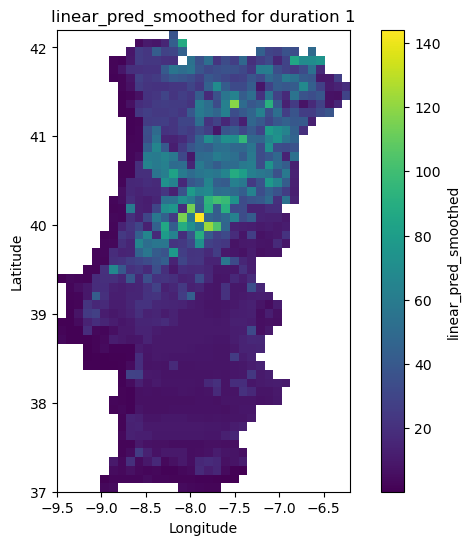

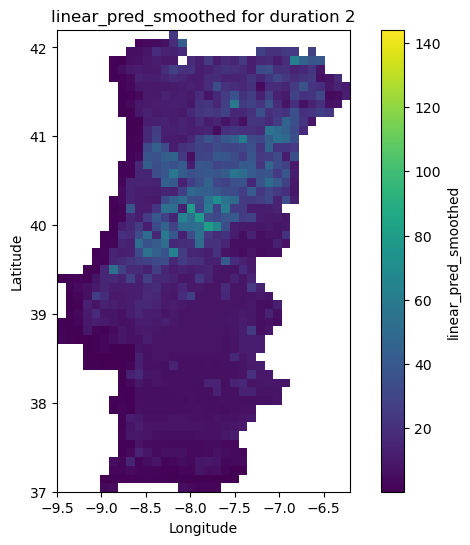

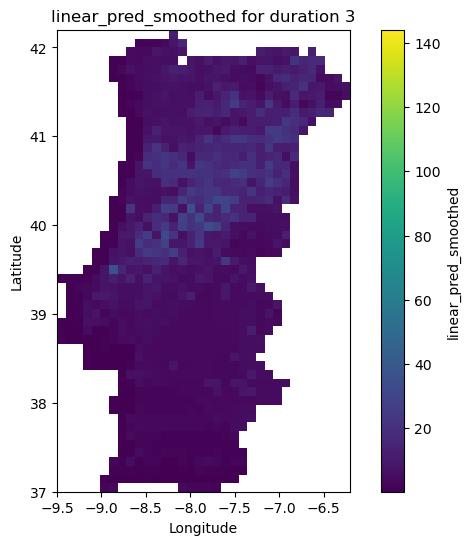

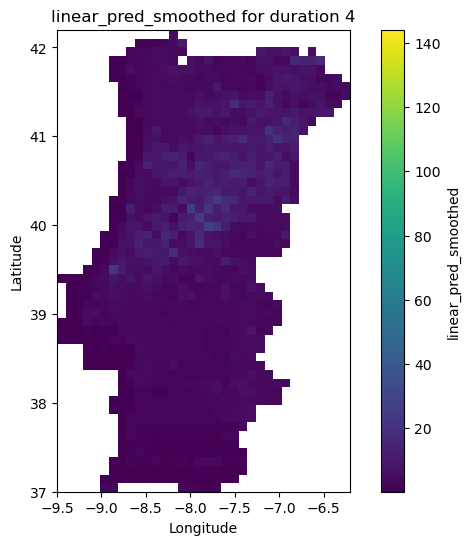

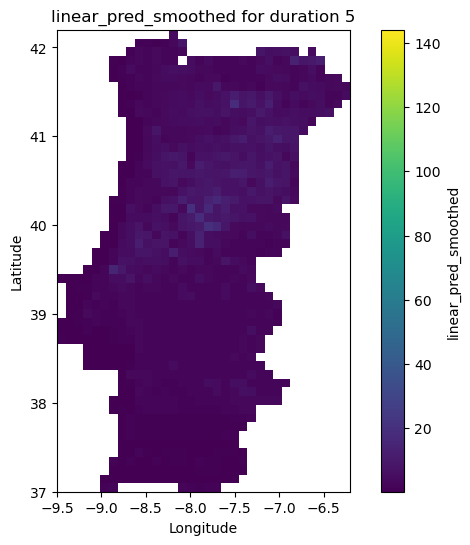

In [13]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# df_slice já contém 'linear_pred_smoothed', 'latitude', 'longitude', 'duration_hours'

# ------------------- Determinar escala global -------------------
vmin = df_slice['linear_pred_smoothed'].min()
vmax = df_slice['linear_pred_smoothed'].max()

for duration in df_slice['duration_hours'].unique():
    # Filtrar pelo duration atual
    df = df_slice[df_slice['duration_hours'] == duration]

    # Ordenar latitudes e longitudes
    lat_vals = np.sort(df['latitude'].unique())
    lon_vals = np.sort(df['longitude'].unique())

    # Criar matriz 2D para linear_pred
    data_grid = np.full((len(lat_vals), len(lon_vals)), np.nan)

    # Preencher a matriz
    for i, lat in enumerate(lat_vals):
        for j, lon in enumerate(lon_vals):
            val = df[(df['latitude'] == lat) & (df['longitude'] == lon)]['linear_pred_smoothed']
            if not val.empty:
                data_grid[i, j] = val.values[0]

    # Criar transform para raster (assumindo grade regular)
    pixel_size_lat = (lat_vals.max() - lat_vals.min()) / (len(lat_vals)-1)
    pixel_size_lon = (lon_vals.max() - lon_vals.min()) / (len(lon_vals)-1)
    transform = from_origin(lon_vals.min()-pixel_size_lon/2, 
                            lat_vals.max()+pixel_size_lat/2, 
                            pixel_size_lon, 
                            pixel_size_lat)

    # Inverter a matriz verticalmente para o TIFF
    data_grid_to_save = np.flipud(data_grid)

    # Salvar TIFF
    output_filename = rf'Data\Output\ros_linear_pred_duration_{duration}.tif'
    with rasterio.open(
        output_filename,
        'w',
        driver='GTiff',
        height=data_grid_to_save.shape[0],
        width=data_grid_to_save.shape[1],
        count=1,
        dtype=data_grid_to_save.dtype,
        crs='EPSG:4326',  # WGS84
        transform=transform,
        nodata=np.nan
    ) as dst:
        dst.write(data_grid_to_save, 1)

    # Plotar com mesma escala para todos os durations
    plt.figure(figsize=(8,6))
    plt.imshow(data_grid, origin='lower',
               extent=(lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()),
               vmin=vmin, vmax=vmax, cmap='viridis')  # mesma escala
    plt.colorbar(label='linear_pred_smoothed')
    plt.title(f'linear_pred_smoothed for duration {duration}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


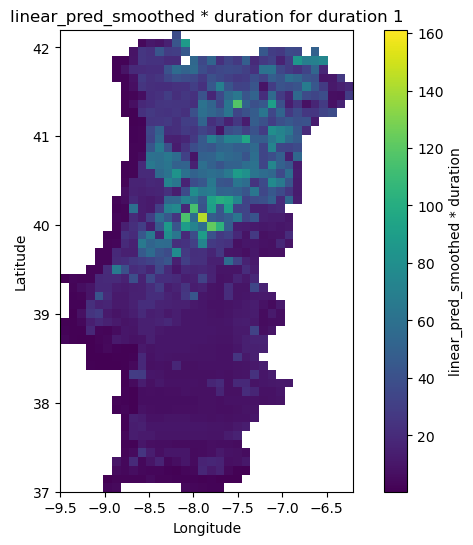

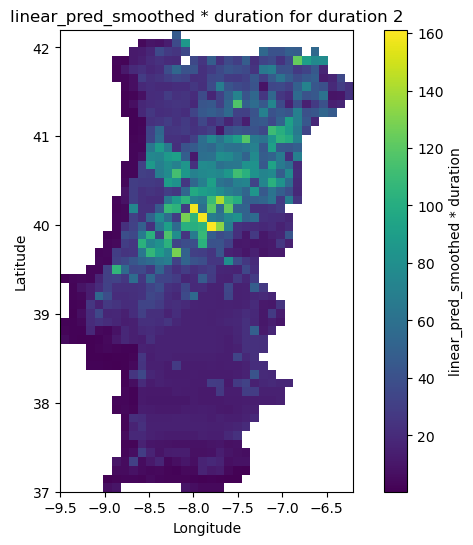

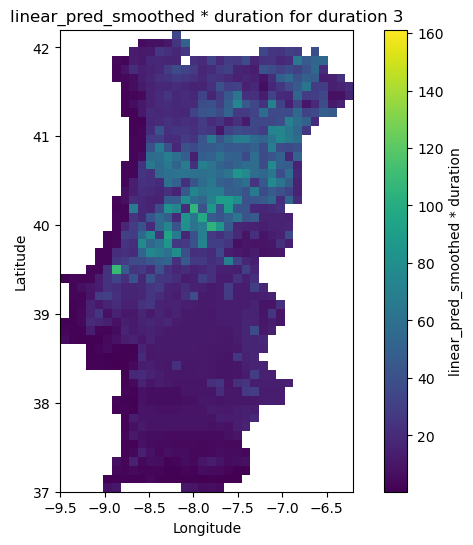

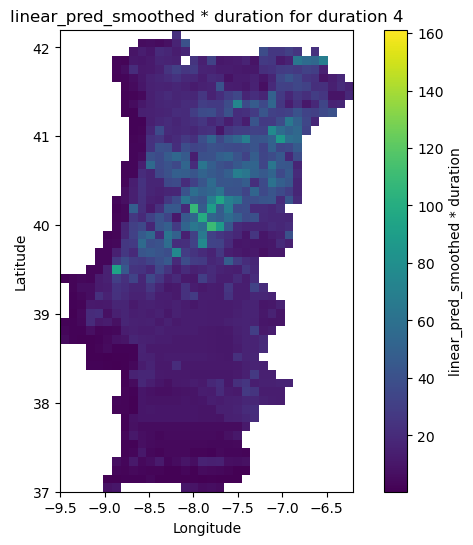

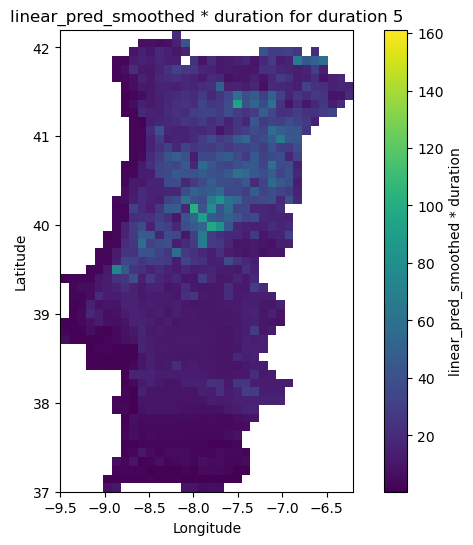

In [14]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# df_slice já contém 'linear_pred_smoothed', 'latitude', 'longitude', 'duration_hours'

# ------------------- Determinar escala global -------------------
# Escala global considerando linear_pred_smoothed * duration
vmin = (df_slice['linear_pred_smoothed'] * df_slice['duration_hours']).min()
vmax = (df_slice['linear_pred_smoothed'] * df_slice['duration_hours']).max()

for duration in df_slice['duration_hours'].unique():
    # Filtrar pelo duration atual
    df = df_slice[df_slice['duration_hours'] == duration]

    # Ordenar latitudes e longitudes
    lat_vals = np.sort(df['latitude'].unique())
    lon_vals = np.sort(df['longitude'].unique())

    # Criar matriz 2D para linear_pred
    data_grid = np.full((len(lat_vals), len(lon_vals)), np.nan)

    # Preencher a matriz
    for i, lat in enumerate(lat_vals):
        for j, lon in enumerate(lon_vals):
            val = df[(df['latitude'] == lat) & (df['longitude'] == lon)]['linear_pred_smoothed']
            if not val.empty:
                data_grid[i, j] = val.values[0] * duration  # multiplicar pelo duration

    # Criar transform para raster (assumindo grade regular)
    pixel_size_lat = (lat_vals.max() - lat_vals.min()) / (len(lat_vals)-1)
    pixel_size_lon = (lon_vals.max() - lon_vals.min()) / (len(lon_vals)-1)
    transform = from_origin(lon_vals.min()-pixel_size_lon/2, 
                            lat_vals.max()+pixel_size_lat/2, 
                            pixel_size_lon, 
                            pixel_size_lat)

    # Inverter a matriz verticalmente para o TIFF
    data_grid_to_save = np.flipud(data_grid)

    # Salvar TIFF
    output_filename = rf'Data\Output\ros_linear_pred_duration_{duration}.tif'
    with rasterio.open(
        output_filename,
        'w',
        driver='GTiff',
        height=data_grid_to_save.shape[0],
        width=data_grid_to_save.shape[1],
        count=1,
        dtype=data_grid_to_save.dtype,
        crs='EPSG:4326',  # WGS84
        transform=transform,
        nodata=np.nan
    ) as dst:
        dst.write(data_grid_to_save, 1)

    # Plotar com mesma escala global
    plt.figure(figsize=(8,6))
    plt.imshow(data_grid, origin='lower',
               extent=(lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()),
               vmin=vmin, vmax=vmax, cmap='viridis')
    plt.colorbar(label='linear_pred_smoothed * duration')
    plt.title(f'linear_pred_smoothed * duration for duration {duration}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


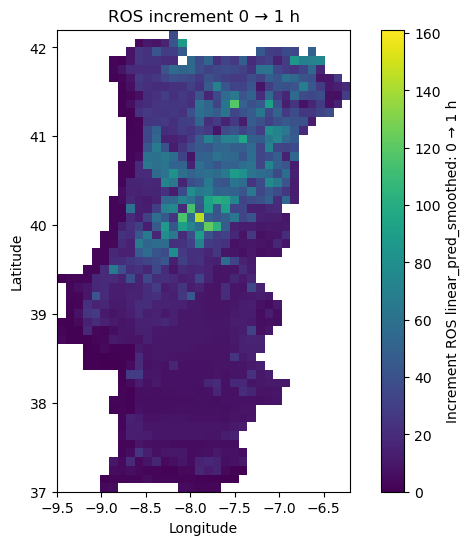

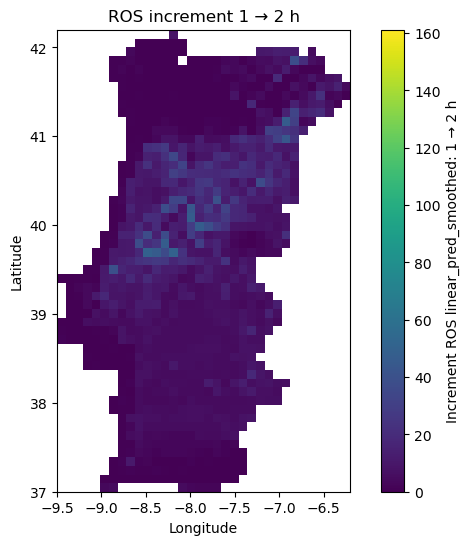

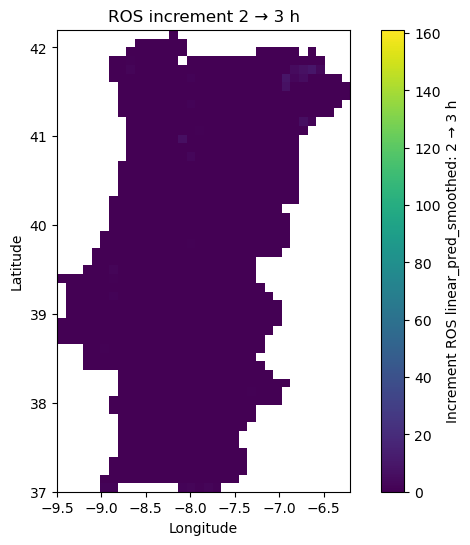

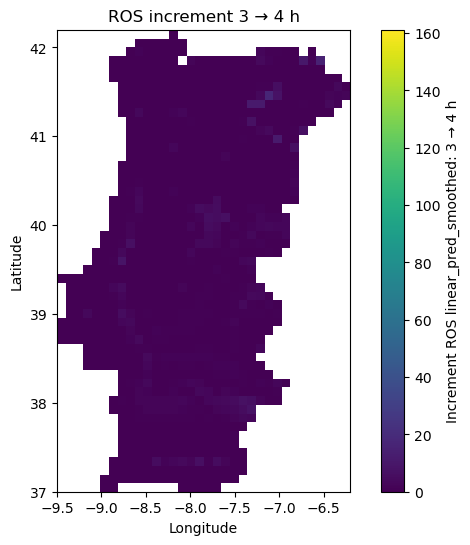

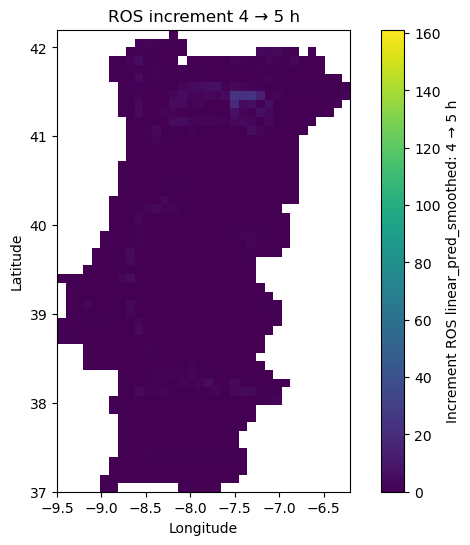

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# df_slice contém: latitude, longitude, duration_hours, linear_pred_smoothed

# Determinar o número máximo de horas
max_duration = int(df_slice['duration_hours'].max())

# Preparar lat/lon
lat_vals = np.sort(df_slice['latitude'].unique())
lon_vals = np.sort(df_slice['longitude'].unique())

# Construir dicionário para fácil acesso: {(lat, lon, duration): value}
value_dict = {
    (row['latitude'], row['longitude'], row['duration_hours']): row['linear_pred_smoothed']
    for _, row in df_slice.iterrows()
}

# Gerar plots de incrementos 0-1, 1-2, 2-3, ..., max_duration-1 → max_duration
for d in range(1, max_duration+1):
    data_grid = np.full((len(lat_vals), len(lon_vals)), np.nan)

    for i, lat in enumerate(lat_vals):
        for j, lon in enumerate(lon_vals):
            curr = value_dict.get((lat, lon, d), np.nan)
            prev = value_dict.get((lat, lon, d-1), 0.0) if d > 1 else 0.0
            data_grid[i,j] = curr * d - prev * (d-1)  # incremento da hora d

    # Escala global para todos os plots
    vmin = 0
    vmax = np.nanmax([value_dict.get((lat, lon, dur), 0.0) * dur for lat in lat_vals
                     for lon in lon_vals for dur in range(1, max_duration+1)])

    plt.figure(figsize=(8,6))
    plt.imshow(data_grid, origin='lower',
               extent=(lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()),
               vmin=vmin, vmax=vmax, cmap='viridis')
    plt.colorbar(label=f'Increment ROS linear_pred_smoothed: {d-1} → {d} h')
    plt.title(f'ROS increment {d-1} → {d} h')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
